In [1]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install numpy==1.24.3

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


# Data preparation and processing 

Import libraries 

In [4]:
import logging
sc.setLogLevel("ERROR")
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql import SparkSession

In [6]:
#Spark session
spark = SparkSession.builder \
    .appName("Tweets") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

In [7]:
# CVS
path = "file:///home/hduser/myenv/ProjectTweets.csv"

df = spark.read.csv(path, header=True, inferSchema=True)

Analysis of the file format 

In [8]:
# DataFrame
df.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- 1467810369: long (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)



In [9]:
df.show()

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [10]:
df.count()

1599999

#Create a new Dataframe from the original file  

In [11]:
from pyspark.sql.types import (IntegerType, StringType, 
                               TimestampType, StructType,
                               StructField, ArrayType,
                               TimestampType)

import pyspark.sql.functions as F

In [12]:
new_schema = StructType([
    StructField("new_number", StringType(), True),
    StructField("new__id", StringType(), True),
    StructField("new_date", StringType(), True),
    StructField("new_flag", StringType(), True),
    StructField("new_user", StringType(), True),
    StructField("new_tweet", StringType(), True)
])

In [13]:
df = spark.createDataFrame(df.rdd, schema=new_schema)
df.printSchema()

root
 |-- new_number: string (nullable = true)
 |-- new__id: string (nullable = true)
 |-- new_date: string (nullable = true)
 |-- new_flag: string (nullable = true)
 |-- new_user: string (nullable = true)
 |-- new_tweet: string (nullable = true)



In [14]:
column_names = df.columns

# Rename columns
for old_name in column_names:
    new_name = old_name.replace("new_", "")
    df = df.withColumnRenamed(old_name, new_name)

df.printSchema()

root
 |-- number: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- tweet: string (nullable = true)



New data frame structure 

In [15]:
df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|number|       _id|                date|    flag|           user|               tweet|
+------+----------+--------------------+--------+---------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|     9|1467812025|Mon Apr 06 22:20:...|NO_

A future projection will be made so the time column is important, the format of that column is displayed to be able to separate it into different columns. 

In [16]:
df.select("date").take(2)

[Row(date='Mon Apr 06 22:19:49 PDT 2009'),
 Row(date='Mon Apr 06 22:19:53 PDT 2009')]

In [17]:
#Import libraries 
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

Day of the week 

In [18]:
def DayWeek(s : str) -> str:
    """
    Converts the string from the tweets to day of week by 
    extracting the first three characters from the string
    
    """
    day      =  s[:3]
    newday  = ""
    
    if day   == "Sun":
        newday = "Sunday"
    elif day == "Mon":
        newday = "Monday"
    elif day == "Tue":
        newday = "Tuesday"
    elif day == "Wed":
        newday = "Wednesday"
    elif day == "Thu":
        newday = "Thursday"
    elif day == "Fri":
        newday = "Friday"
    else:
        newday = "Saturday"
    
    return newday

In [19]:
# Define a User Defined Function (UDF) in Spark to apply the DayWeek function to the data in a DataFrame
DayDF = F.udf(DayWeek, StringType())

In [20]:
df = df.withColumn("DayWeek", DayDF(df["date"]))

In [21]:
df.show()

+------+----------+--------------------+--------+---------------+--------------------+-------+
|number|       _id|                date|    flag|           user|               tweet|DayWeek|
+------+----------+--------------------+--------+---------------+--------------------+-------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...| Monday|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...| Monday|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...| Monday|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...| Monday|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...| Monday|
|     6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug | Monday|
|     7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...| Monday|
|     8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2

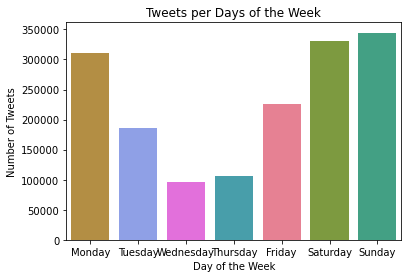

In [22]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Tweets per day
day_week = df.groupBy('DayWeek').count().orderBy('DayWeek').toPandas()

sns.barplot(x='DayWeek', y='count', hue='DayWeek', data=day_week, order=order, palette='husl', legend=False)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Tweets')
plt.title('Tweets per Days of the Week')
plt.show()

In [23]:
#Extract remaining date information in different columns from the original column 

In [24]:
spark = SparkSession.builder \
    .appName("Split Date Column") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

In [25]:
from pyspark.sql.functions import col, to_timestamp

# Timestamp format
df2 = df.withColumn("date", to_timestamp("date", "EEE MMM dd HH:mm:ss zzz yyyy"))

# Year
df2 = df.withColumn("year", df.date.substr(-4, 4))        

df2.show()

+------+----------+--------------------+--------+---------------+--------------------+-------+----+
|number|       _id|                date|    flag|           user|               tweet|DayWeek|year|
+------+----------+--------------------+--------+---------------+--------------------+-------+----+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...| Monday|2009|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...| Monday|2009|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...| Monday|2009|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...| Monday|2009|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...| Monday|2009|
|     6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug | Monday|2009|
|     7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...| Monday|2009|


In [26]:
# Day, Hour and Month
df2 = df2.withColumn("day", df2.date.substr(9, 2))          
df2 = df2.withColumn("hour", df2.date.substr(12, 8))       
df2 = df2.withColumn("month", df2.date.substr(6, 2))        

df2.show()

+------+----------+--------------------+--------+---------------+--------------------+-------+----+---+--------+-----+
|number|       _id|                date|    flag|           user|               tweet|DayWeek|year|day|    hour|month|
+------+----------+--------------------+--------+---------------+--------------------+-------+----+---+--------+-----+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...| Monday|2009| 06|22:19:49|   pr|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...| Monday|2009| 06|22:19:53|   pr|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...| Monday|2009| 06|22:19:57|   pr|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...| Monday|2009| 06|22:19:57|   pr|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...| Monday|2009| 06|22:20:00|   pr|
|     6|1467811592|Mon Apr 06 22:20:...|NO_QUERY

The month extraction was erroneously so the code is changed to correct it. 

In [27]:
from pyspark.sql.functions import month, to_timestamp

df2 = df2.withColumn("date", to_timestamp("date", "EEE MMM dd HH:mm:ss zzz yyyy"))

# Month
df2 = df2.withColumn("month", month("date"))

df2.show()

+------+----------+-------------------+--------+---------------+--------------------+-------+----+---+--------+-----+
|number|       _id|               date|    flag|           user|               tweet|DayWeek|year|day|    hour|month|
+------+----------+-------------------+--------+---------------+--------------------+-------+----+---+--------+-----+
|     1|1467810672|2009-04-07 06:19:49|NO_QUERY|  scotthamilton|is upset that he ...| Monday|2009| 06|22:19:49|    4|
|     2|1467810917|2009-04-07 06:19:53|NO_QUERY|       mattycus|@Kenichan I dived...| Monday|2009| 06|22:19:53|    4|
|     3|1467811184|2009-04-07 06:19:57|NO_QUERY|        ElleCTF|my whole body fee...| Monday|2009| 06|22:19:57|    4|
|     4|1467811193|2009-04-07 06:19:57|NO_QUERY|         Karoli|@nationwideclass ...| Monday|2009| 06|22:19:57|    4|
|     5|1467811372|2009-04-07 06:20:00|NO_QUERY|       joy_wolf|@Kwesidei not the...| Monday|2009| 06|22:20:00|    4|
|     6|1467811592|2009-04-07 06:20:03|NO_QUERY|        

In [28]:
# String
df2 = df2.withColumn("year", col("year").cast("string"))
df2 = df2.withColumn("day", col("day").cast("string"))
df2 = df2.withColumn("hour", col("hour").cast("string"))
df2 = df2.withColumn("month", col("month").cast("string"))

df2.show()

+------+----------+-------------------+--------+---------------+--------------------+-------+----+---+--------+-----+
|number|       _id|               date|    flag|           user|               tweet|DayWeek|year|day|    hour|month|
+------+----------+-------------------+--------+---------------+--------------------+-------+----+---+--------+-----+
|     1|1467810672|2009-04-07 06:19:49|NO_QUERY|  scotthamilton|is upset that he ...| Monday|2009| 06|22:19:49|    4|
|     2|1467810917|2009-04-07 06:19:53|NO_QUERY|       mattycus|@Kenichan I dived...| Monday|2009| 06|22:19:53|    4|
|     3|1467811184|2009-04-07 06:19:57|NO_QUERY|        ElleCTF|my whole body fee...| Monday|2009| 06|22:19:57|    4|
|     4|1467811193|2009-04-07 06:19:57|NO_QUERY|         Karoli|@nationwideclass ...| Monday|2009| 06|22:19:57|    4|
|     5|1467811372|2009-04-07 06:20:00|NO_QUERY|       joy_wolf|@Kwesidei not the...| Monday|2009| 06|22:20:00|    4|
|     6|1467811592|2009-04-07 06:20:03|NO_QUERY|        

Tweets per Month in 2009

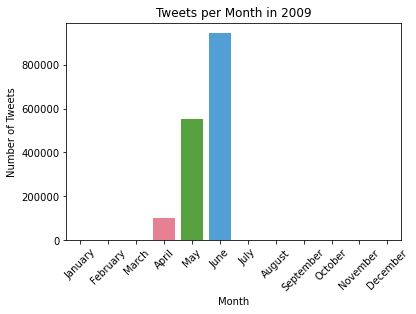

In [29]:
import calendar

order = [calendar.month_name[i] for i in range(1, 13)]

tweets_month = df2.groupBy('month').count().orderBy('month').toPandas()

# Crear el gráfico de barras con colores diferentes para cada mes
sns.barplot(x='month', y='count', hue='month', data=tweets_month, order=range(1, 13), palette='husl', legend=False)
plt.xticks(ticks=range(12), labels=order, rotation=45) 
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.title('Tweets per Month in 2009')
plt.show()

Data cleaning

In [30]:
#Data in Column
df2.select("flag").describe().show()

+-------+--------+
|summary|    flag|
+-------+--------+
|  count| 1599999|
|   mean|    null|
| stddev|    null|
|    min|NO_QUERY|
|    max|NO_QUERY|
+-------+--------+



In [31]:
#Missing Data
Nulls = False
for column in df2.columns:
    if df2.where(col(column).isNull()).count() > 0:
        Nulls = True
        break

if Nulls:
    print("There are null values in the DataFrame.")
else:
    print("There are NO null values in the DataFrame.")

There are NO null values in the DataFrame.


In [32]:
# Drop the columns 
df2 = df2.drop("number","flag","date")

In [33]:
df2.show()

+----------+---------------+--------------------+-------+----+---+--------+-----+
|       _id|           user|               tweet|DayWeek|year|day|    hour|month|
+----------+---------------+--------------------+-------+----+---+--------+-----+
|1467810672|  scotthamilton|is upset that he ...| Monday|2009| 06|22:19:49|    4|
|1467810917|       mattycus|@Kenichan I dived...| Monday|2009| 06|22:19:53|    4|
|1467811184|        ElleCTF|my whole body fee...| Monday|2009| 06|22:19:57|    4|
|1467811193|         Karoli|@nationwideclass ...| Monday|2009| 06|22:19:57|    4|
|1467811372|       joy_wolf|@Kwesidei not the...| Monday|2009| 06|22:20:00|    4|
|1467811592|        mybirch|         Need a hug | Monday|2009| 06|22:20:03|    4|
|1467811594|           coZZ|@LOLTrish hey  lo...| Monday|2009| 06|22:20:03|    4|
|1467811795|2Hood4Hollywood|@Tatiana_K nope t...| Monday|2009| 06|22:20:05|    4|
|1467812025|        mimismo|@twittera que me ...| Monday|2009| 06|22:20:09|    4|
|1467812416| eri

# Sentiment analysis

# Text processing for analysis 

In [34]:
from pyspark.ml.feature import Tokenizer

# tokenize tweets 
tokenizer = Tokenizer(inputCol  = "tweet",
                      outputCol = "token")

df3 = tokenizer.transform(df2)

In [35]:
df3.limit(2).toPandas()

,_id,user,tweet,DayWeek,year,day,hour,month,token
0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,Monday,2009,06,22:19:49,4,"[is, upset, that, he, can't, update, his, face..."
1,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,Monday,2009,06,22:19:53,4,"[@kenichan, i, dived, many, times, for, the, b..."


Removes special characters, call outs and web addresses from tokens

In [36]:
import re

def removeRegex(tokens: list) -> list:
    
    expr    = '(@[A-Za-z0-a9_]+)|(#[A-Za-z0-9_]+)|'+\
              '(https?://[^\s<>"]+|www\.[^\s<>"]+)'
        
    regex   = re.compile(expr)

    cleaned = [t for t in tokens if not(regex.search(t)) if len(t) > 0]

    return list(filter(None, cleaned))

In [37]:
removeWEBUDF = F.udf(removeRegex, ArrayType(StringType()))

Removing non-english characters and returns lower case versions of words.

In [38]:
def normalize(tokens : list) -> list:
    
    subbed   = [re.sub("[^a-zA-Z]+", "", s).lower() for s in tokens]
    
    filtered = filter(None, subbed)
    
    return list(filtered)


normalizeUDF = F.udf(normalize, ArrayType(StringType()))

In [39]:
df3 = df3.withColumn("tokens_re", removeWEBUDF(df3["token"]))

df3 = df3.withColumn("tokens_clean", normalizeUDF(df3["tokens_re"]))

# rename columns
df4 = df3.drop("token","tokens_re")
df4 = df4.withColumnRenamed("tokens_clean", "tokens")

# remove tweets where the tokens array is empty
dfSA= df4.where(F.size(F.col("tokens")) > 0)

In [40]:
dfSA.limit(2).toPandas()

,_id,user,tweet,DayWeek,year,day,hour,month,tokens
0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,Monday,2009,06,22:19:49,4,"[is, upset, that, he, cant, update, his, faceb..."
1,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,Monday,2009,06,22:19:53,4,"[i, dived, many, times, for, the, ball, manage..."


In [41]:
dfSA.show(5)

+----------+-------------+--------------------+-------+----+---+--------+-----+--------------------+
|       _id|         user|               tweet|DayWeek|year|day|    hour|month|              tokens|
+----------+-------------+--------------------+-------+----+---+--------+-----+--------------------+
|1467810672|scotthamilton|is upset that he ...| Monday|2009| 06|22:19:49|    4|[is, upset, that,...|
|1467810917|     mattycus|@Kenichan I dived...| Monday|2009| 06|22:19:53|    4|[i, dived, many, ...|
|1467811184|      ElleCTF|my whole body fee...| Monday|2009| 06|22:19:57|    4|[my, whole, body,...|
|1467811193|       Karoli|@nationwideclass ...| Monday|2009| 06|22:19:57|    4|[no, its, not, be...|
|1467811372|     joy_wolf|@Kwesidei not the...| Monday|2009| 06|22:20:00|    4|[not, the, whole,...|
+----------+-------------+--------------------+-------+----+---+--------+-----+--------------------+
only showing top 5 rows



In [42]:
df5=dfSA

In [45]:
#format yyyy-MM-dd
from pyspark.sql import functions as F

df5 = df5.withColumn("day", F.lpad(F.col("day"), 2, '0'))
df5 = df5.withColumn("month", F.lpad(F.col("month"), 2, '0'))

df5 = df5.withColumn("date_str", F.concat(F.col("year"), F.lit("-"), F.col("month"), F.lit("-"), F.col("day")))

df5 = df5.withColumn("date", F.to_date(F.col("date_str"), "yyyy-MM-dd"))

df5 = df5.drop("date_str", "day", "month", "year")

In [46]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.corpus import stopwords

In [48]:
# stopwords
remove_stopwords_udf = udf(lambda tokens: [word for word in tokens if word.lower() not in stopwords.words('english')], StringType())

# Remove stopwords
df5 = df5.withColumn("tokens", remove_stopwords_udf(df5["tokens"]))

+----------+---------------+--------------------+-------+--------+--------------------+----------+
|       _id|           user|               tweet|DayWeek|    hour|              tokens|      date|
+----------+---------------+--------------------+-------+--------+--------------------+----------+
|1467810672|  scotthamilton|is upset that he ...| Monday|22:19:49|[upset, cant, upd...|2009-04-06|
|1467810917|       mattycus|@Kenichan I dived...| Monday|22:19:53|[dived, many, tim...|2009-04-06|
|1467811184|        ElleCTF|my whole body fee...| Monday|22:19:57|[whole, body, fee...|2009-04-06|
|1467811193|         Karoli|@nationwideclass ...| Monday|22:19:57|[behaving, im, ma...|2009-04-06|
|1467811372|       joy_wolf|@Kwesidei not the...| Monday|22:20:00|       [whole, crew]|2009-04-06|
|1467811592|        mybirch|         Need a hug | Monday|22:20:03|         [need, hug]|2009-04-06|
|1467811594|           coZZ|@LOLTrish hey  lo...| Monday|22:20:03|[hey, long, time,...|2009-04-06|
|146781179

In [49]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk

# Lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

#Lemmatize and stem function
def lemmatize_and_stem(tokens):
    lemmatized_stemmed_tokens = [stemmer.stem(lemmatizer.lemmatize(word)) for word in tokens]
    return lemmatized_stemmed_tokens

lemmatize_and_stem_udf = udf(lemmatize_and_stem, ArrayType(StringType()))

df5 = df5.withColumn("tokens", lemmatize_and_stem_udf(df5["tokens"]))

+----------+-------------+--------------------+-------+--------+--------------------+----------+
|       _id|         user|               tweet|DayWeek|    hour|              tokens|      date|
+----------+-------------+--------------------+-------+--------+--------------------+----------+
|1467810672|scotthamilton|is upset that he ...| Monday|22:19:49|[upset, cant, upd...|2009-04-06|
|1467810917|     mattycus|@Kenichan I dived...| Monday|22:19:53|[dive, mani, time...|2009-04-06|
|1467811184|      ElleCTF|my whole body fee...| Monday|22:19:57|[whole, bodi, fee...|2009-04-06|
|1467811193|       Karoli|@nationwideclass ...| Monday|22:19:57|[behav, im, mad, ...|2009-04-06|
|1467811372|     joy_wolf|@Kwesidei not the...| Monday|22:20:00|       [whole, crew]|2009-04-06|
+----------+-------------+--------------------+-------+--------+--------------------+----------+
only showing top 5 rows



In [50]:
from pyspark.sql.functions import length

#  Length
df5 = df5.withColumn("tweet_length", length(col("tweet")))

+----------+-------------+--------------------+-------+--------+--------------------+----------+------------+
|       _id|         user|               tweet|DayWeek|    hour|              tokens|      date|tweet_length|
+----------+-------------+--------------------+-------+--------+--------------------+----------+------------+
|1467810672|scotthamilton|is upset that he ...| Monday|22:19:49|[upset, cant, upd...|2009-04-06|         111|
|1467810917|     mattycus|@Kenichan I dived...| Monday|22:19:53|[dive, mani, time...|2009-04-06|          89|
|1467811184|      ElleCTF|my whole body fee...| Monday|22:19:57|[whole, bodi, fee...|2009-04-06|          47|
|1467811193|       Karoli|@nationwideclass ...| Monday|22:19:57|[behav, im, mad, ...|2009-04-06|         111|
|1467811372|     joy_wolf|@Kwesidei not the...| Monday|22:20:00|       [whole, crew]|2009-04-06|          29|
+----------+-------------+--------------------+-------+--------+--------------------+----------+------------+
only showi

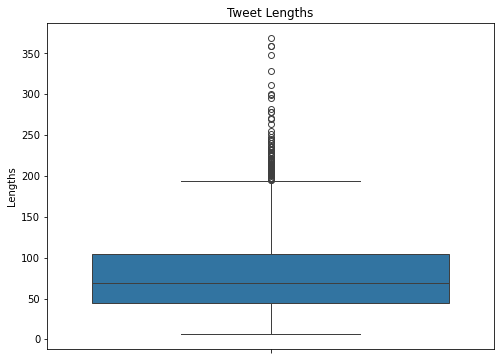

In [51]:
#Lengths
df5 = df5.withColumn("tweet_length", df5["tweet_length"].cast("int"))


pandas_df = df5.select('tweet_length').toPandas()
plt.figure(figsize=(8, 6))
sns.boxplot(data=pandas_df, y='tweet_length')
plt.title('Tweet Lengths')
plt.ylabel('Lengths')
plt.grid(False)
plt.show()

In [52]:
from pyspark.ml.feature import HashingTF, IDF, SQLTransformer
from pyspark.ml import Pipeline

# TF
hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeaturesNew", numFeatures=10000)

# IDF
idf = IDF(inputCol="rawFeaturesNew", outputCol="idfFeatures") 

sql_transformer = SQLTransformer(statement="SELECT tokens, * FROM __THIS__")

# Pipeline 
pipeline = Pipeline(stages=[sql_transformer, hashingTF, idf])

pipeline_model = pipeline.fit(df5)
df6 = pipeline_model.transform(df5)

In [58]:
spark = SparkSession.builder \
    .appName("Tweets_JSON") \
    .getOrCreate()

df_json = spark.read.json("file:///home/hduser/myenv/ProjectTweets2.json")

df_json.printSchema()
df_json.show(5)

root
 |-- DayWeek: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- idfFeatures: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- rawFeaturesNew: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- tweet: string (nullable = true)
 |-- tweet_length: long (nullable = true)
 |-- user: string (nullable = true)

+-------+----------+----------+--------+--------------------+--------------------+--------------------+-------